In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fkms.algorithms import *
import os
import json
import sys
import time
import math

sys.path.append("..")
from plot_notebooks.plotfunctions import plot_range
from common import *

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import rand_score, adjusted_rand_score
from sklearn.cluster import kmeans_plusplus
from sklearn.metrics import silhouette_score
import fed_kmeans_V2 as fkm

In [2]:
def run_kfed(n_clients, n_runs, data_choice, k_local, betas = None):
    scores = np.zeros((n_clients, n_runs))

    datasets = []
    labels = []
    for i in range(n_clients):
        dataset, label = load_data(i, data_choice, betas)
        datasets.append(dataset)
        labels.append(label)

    for j in range(n_runs):    
        _, centers = kfed(datasets, k_local, k, useSKLearn = True, sparse=False)
        scores[:,j] = calc_ARI(centers, datasets, labels )
        
    return(weighted_avg(scores, [dset.shape[0] for dset in datasets]))
        

# FEMNIST
## Dennis et al.

In [5]:
n_clients = 10

datasets_FEMNIST = []

for i in range(n_clients):
    datasets_FEMNIST.append(np.genfromtxt("data/MNIST/MNIST_cluster_client" + str(i) + ".csv", delimiter = ","))

In [17]:
k = 60
local_ks = [21]
n_runs = 100
silh_score_DS = np.zeros((n_runs))
simpl_silh_score_DS = np.zeros_like(silh_score_DS)

start_time = time.time()

for local_k in local_ks:
    for r in range(n_runs):
        _, centers_fed = kfed(datasets_FEMNIST, local_k, k, useSKLearn = True, sparse = False )
        silh_score_DS[r] = calc_silhouette_score(np.vstack(datasets_FEMNIST), centers_fed)
        simpl_silh_score_DS[r] = calc_simpl_silh_score(datasets_FEMNIST, centers_fed)
    print("mean silh score for local_k = ", local_k, ": ", np.mean(silh_score_DS))
print("time elapsed: ", (time.time() - start_time)/60)

mean silh score for local_k =  21 :  0.08348250146652639
time elapsed:  7.97469851175944


In [7]:
k = 60
local_ks = [60]
n_runs = 100
silh_score_DS_untuned = np.zeros((n_runs))
simpl_silh_score_DS_untuned = np.zeros_like(silh_score_DS)

start_time = time.time()

for local_k in local_ks:
    for r in range(n_runs):
        _, centers_fed = kfed(datasets_FEMNIST, local_k, k, useSKLearn = True, sparse = False )
        silh_score_DS_untuned[r] = calc_silhouette_score(np.vstack(datasets_FEMNIST), centers_fed)
        simpl_silh_score_DS_untuned[r] = calc_simpl_silh_score(datasets_FEMNIST, centers_fed)
    print("mean silh score for local_k = ", local_k, ": ", np.mean(silh_score_DS))
print("time elapsed: ", (time.time() - start_time)/60)

mean silh score for local_k =  60 :  0.0
time elapsed:  1.044797917207082


In [9]:
np.savetxt("femnist_ds_untuned.csv", silh_score_DS_untuned, delimiter = ",")

## Central

In [18]:
dataset_FEMNIST = np.vstack(datasets_FEMNIST)
n_runs = 100
silh_score_C = np.zeros((n_runs))
simpl_silh_score_C = np.zeros_like(silh_score_DS)
k = 60
ks = [60]

start_time = time.time()
for k in ks:
    for r in range(n_runs):
        #print("run ", r)
        km = KMeans(n_clusters= k).fit(dataset_FEMNIST)
        centers_cent = np.copy(km.cluster_centers_)
        silh_score_C[r] = calc_silhouette_score(dataset_FEMNIST, centers_cent)
        simpl_silh_score_C[r] = calc_simpl_silh_score(datasets_FEMNIST, centers_cent)
    print("mean silh score for k = ", k, ": ", np.mean(silh_score_C))
print("time elapsed: ", (time.time() - start_time)/60)

mean silh score for k =  60 :  0.10230024801908506
time elapsed:  5.302265532811483


## Own Method, V2

In [3]:
n_runs = 100
n_global = 60
crounds = 10

scores_FEMNIST_V2 = fkm.run_V2(n_global, n_runs= n_runs, crounds = 10, dset = 'FEMNIST')


In [6]:
scores_FEMNIST_V2[0,:]

array([0.09265299, 0.10343706, 0.09332174, 0.0994982 , 0.09023537,
       0.08390654, 0.09222812, 0.09737382, 0.10766473, 0.09424832,
       0.09940833, 0.09530334, 0.09417857, 0.08969113, 0.0960553 ,
       0.09308568, 0.09270879, 0.09370862, 0.09409368, 0.0994984 ,
       0.09146395, 0.09163246, 0.10135827, 0.09724961, 0.10580191,
       0.08820427, 0.08942157, 0.09572118, 0.09345704, 0.10305417,
       0.08548451, 0.09452601, 0.09227726, 0.08923207, 0.09733341,
       0.09022964, 0.09718545, 0.09588384, 0.09339587, 0.09662744,
       0.09543056, 0.09622942, 0.10405581, 0.08855434, 0.09034035,
       0.09115161, 0.0883763 , 0.09800085, 0.0916757 , 0.09089812,
       0.09847252, 0.08987955, 0.10040357, 0.09265449, 0.10378471,
       0.09926061, 0.09506806, 0.0903756 , 0.09497174, 0.09052062,
       0.09684507, 0.09266689, 0.0961295 , 0.09680848, 0.09831462,
       0.09184022, 0.09949981, 0.10687181, 0.09539512, 0.09249836,
       0.09423612, 0.09998766, 0.09988865, 0.09614029, 0.09565

In [7]:
np.savetxt("femnist_V2.csv", scores_FEMNIST_V2[0,:], delimiter = ",")

## Own Method
'natural' t

In [37]:
n_clients = 10
n_cluster_global = 60
crounds = 10
n_runs = 100 


n_dim = 784
t= None
silh_score_OM_natt = np.zeros((n_runs))
simpl_silh_score_OM_natt = np.zeros_like(silh_score_OM_natt)

full_scores = np.zeros((crounds, n_clients, n_runs))
avg_scores_tmp = np.zeros((crounds, n_runs))
all_means = np.zeros((n_cluster_global, n_dim, n_runs))

# init clients and server
#clients = [client(np.genfromtxt(datafiles[i], delimiter=','), np.genfromtxt(labelfiles[i], delimiter=','), n_cluster_global) for i in range(n_clients)]
clients = []
for i in range(n_clients):
    clients.append(client(datasets_FEMNIST[i], None, n_cluster_global))

server_obj = server(n_cluster_global, n_dim)


for r in range(n_runs):
    means_federated, _ = run(clients, server_obj, crounds, n_clients, n_cluster_global,dim = n_dim, t = t)#, alpha, Xmin, Xmax, Ymin, Ymax)
    all_means[:,:,r] = means_federated
    silh_score_OM_natt[r] = calc_silhouette_score(np.vstack(datasets_FEMNIST), all_means[:,:,r])
    simpl_silh_score_OM_natt[r] = calc_simpl_silh_score(datasets_FEMNIST, all_means[:,:,r])

finetuned t (t = 3)

In [26]:
n_clients = 10
n_cluster_global = 60
crounds = 10
n_runs = 100 


n_dim = 784
t= 3
silh_score_OM = np.zeros((n_runs))
simpl_silh_score_OM = np.zeros_like(silh_score_OM)

full_scores = np.zeros((crounds, n_clients, n_runs))
avg_scores_tmp = np.zeros((crounds, n_runs))
all_means = np.zeros((n_cluster_global, n_dim, n_runs))

# init clients and server
#clients = [client(np.genfromtxt(datafiles[i], delimiter=','), np.genfromtxt(labelfiles[i], delimiter=','), n_cluster_global) for i in range(n_clients)]
clients = []
for i in range(n_clients):
    clients.append(client(datasets_FEMNIST[i], None, n_cluster_global))

server_obj = server(n_cluster_global, n_dim)


for r in range(n_runs):
    means_federated, _ = run(clients, server_obj, crounds, n_clients, n_cluster_global,dim = n_dim, t = t)#, alpha, Xmin, Xmax, Ymin, Ymax)
    all_means[:,:,r] = means_federated
    silh_score_OM[r] = calc_silhouette_score(np.vstack(datasets_FEMNIST), all_means[:,:,r])
    simpl_silh_score_OM[r] = calc_simpl_silh_score(datasets_FEMNIST, all_means[:,:,r])

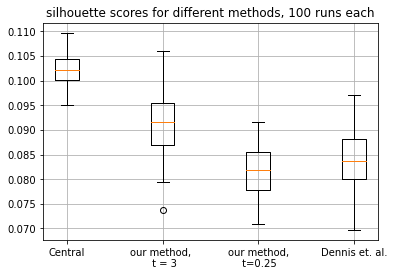

In [61]:
plt.boxplot([silh_score_C, silh_score_OM, silh_score_OM_natt, silh_score_DS], positions = [0,2,4,6])
plt.xticks([0,2,4,6],["Central", "our method, \n t = 3", "our method,\n t=0.25","Dennis et. al."])
plt.title("silhouette scores for different methods, 100 runs each")
plt.grid(True)
plt.savefig("FEMNIST_silh.eps",format = "eps")

In [86]:
# save data
np.savetxt("femnist_om.csv", silh_score_OM, delimiter = ",")
np.savetxt("femnist_om_natt.csv", silh_score_OM_natt, delimiter = ",")
np.savetxt("femnist_ds.csv", silh_score_DS, delimiter = ",")
np.savetxt("femnist_cent.csv", silh_score_C, delimiter = ",")

# (Original) synthetic dataset
## Dennis et. al.

In [25]:
betas = [0.1, 1, 10]
n_clients = 5
k = 16
k_locals = [16, 16, 16]
n_runs = 200
data_choice = "regular"

scores = np.zeros((n_clients, n_runs, len(betas)))
for beta_i, (beta, k_local) in enumerate(zip(betas, k_locals)):
    

    datasets = []
    labels = []
    for i in range(n_clients):
        dataset, label = load_data(i, data_choice, beta)
        datasets.append(dataset)
        labels.append(label)

    for j in range(n_runs):    
        _, centers = kfed(datasets, k_local, k, useSKLearn = True, sparse=False)
        scores[:,j, beta_i] = calc_ARI(centers, datasets, labels )


tot_samples = 0
avg_scores_DS = np.zeros((n_runs, len(betas)))
for dset_i, dset in enumerate(datasets):
    n_s = len(dset)
    avg_scores_DS += n_s * scores[dset_i, :,:]
    tot_samples += n_s

avg_scores_DS /= tot_samples

## Central

In [71]:
n_runs = 200
betas = [0.1, 1, 10]
scores_central_orig = np.zeros((n_runs, len(betas)))

for j, beta in enumerate(betas):
    datasets = []
    labels = []
    for i in range(5):
        dataset, label = load_data(i, "regular", beta)
        datasets.append(dataset)
        labels.append(label)

    data_full, labels_full = stack_data(datasets, labels)
    for n_run in range(n_runs):
        kmeans_cent = KMeans(n_clusters = 16, random_state=0 + n_run).fit(data_full)
        scores_central_orig[n_run, j] = adjusted_rand_score(labels_full, kmeans_cent.labels_)

In [3]:
n_runs = 200
beta = 0.1
ppcs = 50, 100, 200
noises = [1, 1.1, 1.2, 1.3, 1.4, 1.5]
scores_central_abl = np.zeros((n_runs, len(ppcs), len(noises)))

for j, ppc in enumerate(ppcs):
    for k, noise in enumerate(noises):
        datasets = []
        labels = []
        for i in range(5):
            dataset, label = load_data(i, "abl", beta = beta, ppc = ppc, noise = noise)
            datasets.append(dataset)
            labels.append(label)
        data_full, labels_full = stack_data(datasets, labels)
        for n_run in range(n_runs):
            kmeans_cent = KMeans(n_clusters = 16, random_state=0 + n_run).fit(data_full)
            scores_central_abl[n_run, j, k] = adjusted_rand_score(labels_full, kmeans_cent.labels_)

In [5]:
with open("scores_central_abl", "wb") as f:
    np.save(f, scores_central_abl)

## Own method

In [47]:
n_clients = 5
n_cluster_global = 16
crounds = 3
n_runs = 200
betas = [0.1, 1, 10]
dset = "regular"
full_scores = np.zeros((n_clients, n_runs, len(betas)))
avg_scores = np.zeros((n_runs, len(betas)))
per_round_scores = np.zeros((n_clients, n_runs, crounds, len(betas)))
avg_per_round_scores = np.zeros((n_runs, crounds, len(betas)))
all_means = np.zeros((n_cluster_global, 2, n_runs, len(betas)))
for beta_i, beta in enumerate(betas):
    # init clients and server
    #clients = [client(np.genfromtxt(datafiles[i], delimiter=','), np.genfromtxt(labelfiles[i], delimiter=','), n_cluster_global) for i in range(n_clients)]
    clients = []
    for i in range(n_clients):
        data, labels = load_data(i, dset, beta,)
        clients.append(client(data, labels, n_cluster_global))

    server_obj = server(n_cluster_global, 2)


    for r in range(n_runs):
        means_federated, scores = run(clients, server_obj, crounds, n_clients, n_cluster_global)
        full_scores[:,r, beta_i] = scores[:,-1] #only save ARI from last round
        per_round_scores[:, r, :, beta_i] = scores
        all_means[:,:,r, beta_i] = means_federated

    # calculate the (weighted) mean ARI for all clients combined
    tot_samples = 0
    #fed_mean = np.zeros(n_runs)
    for client_i, client_o in enumerate(clients):
        n_s = len(client_o.labels)
        avg_per_round_scores[:, :, beta_i] += n_s * per_round_scores[client_i, :, :, beta_i]
        avg_scores[:,beta_i] += n_s * full_scores[client_i, :, beta_i]
        tot_samples += n_s

    avg_scores[:,beta_i] /= tot_samples

## V2

In [4]:
n_runs = 200
n_global = 16
crounds = 10
betas = [0.1, 1, 10]
all_scores_V2 = []
for beta in betas:
    scores = fkm.run_V2(n_global, n_runs= n_runs, crounds = 10, beta = beta)
    all_scores_V2.append(scores)

In [5]:
n_runs = 200
n_global = 16
crounds = 10
betas = [0.1, 1, 10]
ppcs = [50, 100, 200]
noises = [1, 1.1, 1.2, 1.3, 1.4, 1.5]
all_scores_V2 = np.zeros((crounds, n_runs, len(betas), len(ppcs), len(noises)))
for i, beta in enumerate(betas):
    for j, ppc in enumerate(ppcs):
        for k, noise in enumerate(noises):
            all_scores_V2[:,:,i,j,k]= fkm.run_V2(n_global, n_runs= n_runs, crounds = 10, beta = beta, dset='abl', ppc = ppc, noise = noise )

In [7]:
with open("abl_V2.npy", "wb") as f:
    np.save(f, all_scores_V2)

In [7]:
n_runs = 200
n_global = 16
crounds = 10
betas = [0.01]
all_scores_V2 = []
for beta in betas:
    scores = fkm.run_V2(n_global, n_runs= n_runs, crounds = 10, beta = beta, dset = 'abl', ppc=50)
    all_scores_V2.append(scores)

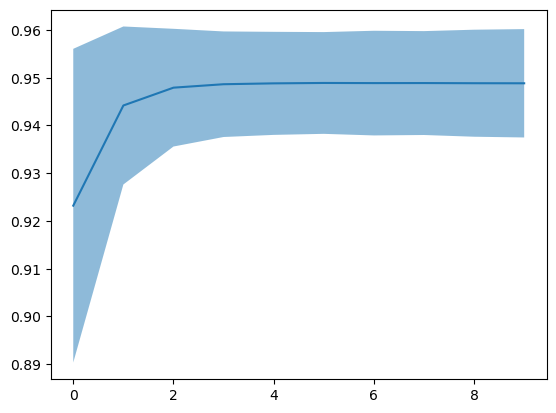

In [9]:
plot_range(all_scores_V2[0].T)

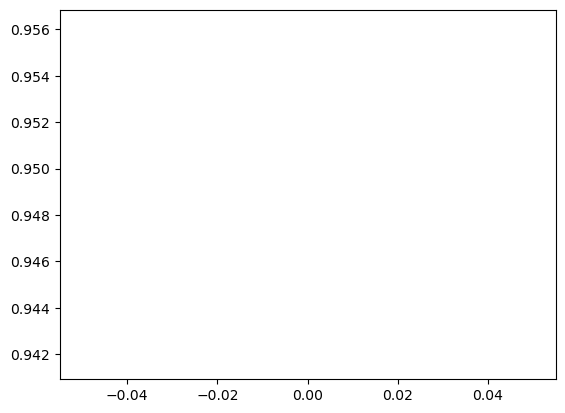

In [5]:
plt

In [8]:
all_scores_V2[0].shape

(10, 200)

Text(0, 0.5, 'ARI')

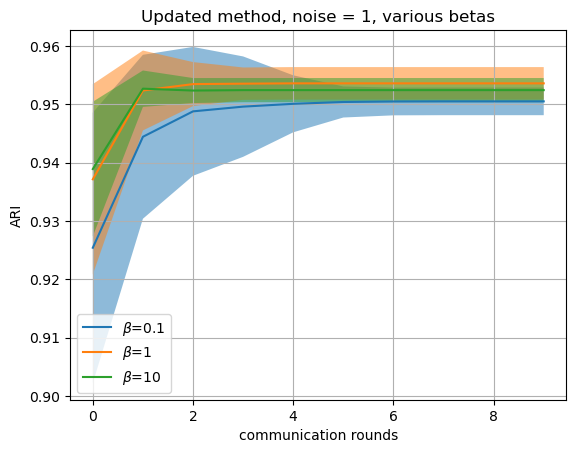

In [21]:
plot_range(all_scores_V2[0].T, label = r"$\beta$=0.1")
plot_range(all_scores_V2[1].T, label = r"$\beta$=1")
plot_range(all_scores_V2[2].T, label = r"$\beta$=10")
plt.grid(True)
plt.title("Updated method, noise = 1, various betas")
plt.legend()
plt.xlabel("communication rounds")
plt.ylabel("ARI")

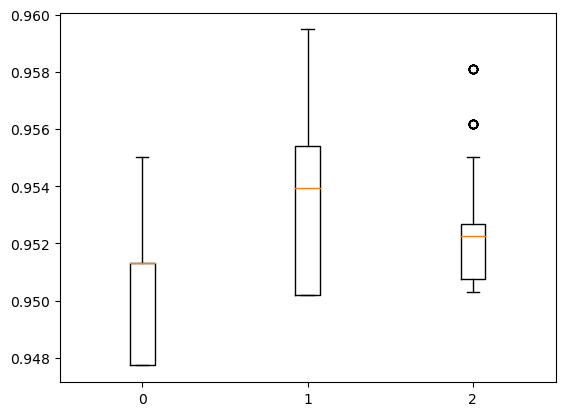

In [10]:
for i, score in enumerate(all_scores_V2):
    plt.boxplot(score[-1,:], positions = [i])

In [11]:

np.savetxt("V2_beta01.csv", all_scores_V2[0], delimiter = ",")

In [12]:
np.savetxt("V2_beta1.csv", all_scores_V2[1], delimiter = ",")
np.savetxt("V2_beta10.csv", all_scores_V2[2], delimiter = ",")

In [78]:
bp3['boxes'][0]

In [102]:
avg_scores_DS.shape

(200, 3)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


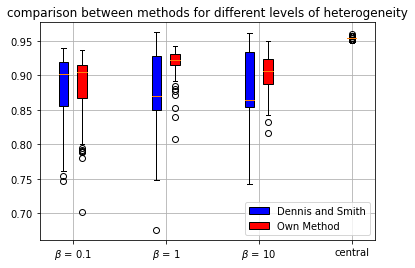

In [84]:
bp1 = plt.boxplot(avg_scores_DS, positions = [-0.2, 1.8, 3.8], widths = 0.2, patch_artist = True, boxprops=dict(facecolor="blue"))
bp2 = plt.boxplot(avg_scores, positions = [0.2, 2.2, 4.2], widths = 0.2, patch_artist = True, boxprops=dict(facecolor="red"))
bp3 = plt.boxplot(scores_central_orig[:,0], positions = [6], widths = 0.2, patch_artist = True, boxprops=dict(facecolor="purple"))
#plt.ylim([0.7, 1])
plt.xticks([0, 2, 4, 6], [r"$\beta$ = 0.1",r"$\beta$ = 1",r"$\beta$ = 10", "central"])
plt.grid(True)
plt.legend([bp1['boxes'][0], bp2['boxes'][0]], ["Dennis and Smith", "Own Method"])
plt.title("comparison between methods for different levels of heterogeneity")
plt.savefig("synth_orig.eps",format = "eps")

In [103]:
# save data
np.savetxt("om_synth_orig.csv", avg_scores, delimiter = ",")
np.savetxt("ds_synth_orig.csv", avg_scores_DS, delimiter = ",")
np.savetxt("cent_synth_orig.csv", scores_central_orig, delimiter = ",")

# Synthetic, high imbalance in clusters
## Dennis et. al.

In [46]:
n_clients = 5
k = 16
k_local = 14
n_runs = 200
data_choice = "cluster_wise"

scores = np.zeros((n_clients, n_runs))

datasets = []
labels = []
for i in range(n_clients):
    dataset, label = load_data(i, data_choice)
    datasets.append(dataset)
    labels.append(label)

for j in range(n_runs):    
    _, centers = kfed(datasets, k_local, k, useSKLearn = True, sparse=False)
    scores[:,j] = calc_ARI(centers, datasets, labels )


tot_samples = 0
avg_scores_DS_cw = np.zeros((n_runs))
for dset_i, dset in enumerate(datasets):
    n_s = len(dset)
    avg_scores_DS_cw += n_s * scores[dset_i, :]
    tot_samples += n_s

avg_scores_DS_cw /= tot_samples

## Central

In [73]:
n_runs = 200

scores_central_cw = np.zeros((n_runs))


datasets = []
labels = []
for i in range(5):
    dataset, label = load_data(i, "cluster_wise")
    datasets.append(dataset)
    labels.append(label)

data_full, labels_full = stack_data(datasets, labels)
for n_run in range(n_runs):
    kmeans_cent = KMeans(n_clusters = 16, random_state=0 + n_run).fit(data_full)
    scores_central_cw[n_run] = adjusted_rand_score(labels_full, kmeans_cent.labels_)

## Own method

In [45]:
n_clients = 5
n_cluster_global = 16
crounds = 3
n_runs = 200
#betas = [0.1, 1, 10]
dset = "cluster_wise"
full_scores = np.zeros((n_clients, n_runs))
avg_scores_cluster_wise = np.zeros((n_runs))
per_round_scores = np.zeros((n_clients, n_runs, crounds))
avg_per_round_scores = np.zeros((n_runs, crounds))
all_means = np.zeros((n_cluster_global, 2, n_runs))
#for beta_i, beta in enumerate(betas):
    # init clients and server
    #clients = [client(np.genfromtxt(datafiles[i], delimiter=','), np.genfromtxt(labelfiles[i], delimiter=','), n_cluster_global) for i in range(n_clients)]
clients = []
for i in range(n_clients):
    data, labels = load_data(i, dset)
    clients.append(client(data, labels, n_cluster_global))

server_obj = server(n_cluster_global, 2)


for r in range(n_runs):
    #print("")
    means_federated, scores = run(clients, server_obj, crounds, n_clients, n_cluster_global)
    full_scores[:,r] = scores[:,-1] #only save ARI from last round
    per_round_scores[:, r, :] = scores
    all_means[:,:,r] = means_federated

# calculate the (weighted) mean ARI for all clients combined
tot_samples = 0
for client_i, client_o in enumerate(clients):
    n_s = len(client_o.labels)
    avg_per_round_scores[:, :] += n_s * per_round_scores[client_i, :, :]
    avg_scores_cluster_wise += n_s * full_scores[client_i, :]
    tot_samples += n_s

avg_scores_cluster_wise /= tot_samples

In [3]:
n_runs = 200
n_global = 16
crounds = 10
beta = 0.1
cluster_wise_V2 = fkm.run_V2(n_global, n_runs= n_runs, crounds = 10, beta = beta, dset='cluster_wise')

In [5]:
np.savetxt("cluster_wise_V2.csv", cluster_wise_V2, delimiter = ",")

## Plots

Text(0.5, 1.0, 'ARI comparison on cluster imbalanced dataset')

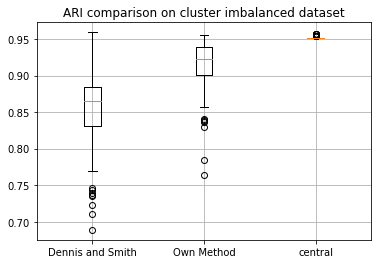

In [88]:
plt.boxplot(avg_scores_DS_cw, positions = [0])
plt.boxplot(avg_scores_cluster_wise, positions = [1])
plt.boxplot(scores_central_cw, positions = [2])
plt.xticks([0, 1,2], ["Dennis and Smith", "Own Method", "central"])
plt.grid(True)
plt.title("ARI comparison on cluster imbalanced dataset")

In [89]:
# save data
np.savetxt("om_synth_ci.csv", avg_scores_cluster_wise, delimiter = ",")
np.savetxt("ds_synth_ci.csv", avg_scores_DS_cw, delimiter = ",")
np.savetxt("cent_synth_ci.csv", scores_central_cw, delimiter = ",")

# Synthetic, non-uniform in field
## Dennis et. al.

In [49]:
n_clients = 5
k = 12
k_local = 12
n_runs = 200
data_choice = "super_diag"

scores = np.zeros((n_clients, n_runs))

datasets = []
labels = []
for i in range(n_clients):
    dataset, label = load_data(i, data_choice)
    datasets.append(dataset)
    labels.append(label)

for j in range(n_runs):    
    _, centers = kfed(datasets, k_local, k, useSKLearn = True, sparse=False)
    scores[:,j] = calc_ARI(centers, datasets, labels )


tot_samples = 0
avg_scores_DS_SD = np.zeros((n_runs))
for dset_i, dset in enumerate(datasets):
    n_s = len(dset)
    avg_scores_DS_SD += n_s * scores[dset_i, :]
    tot_samples += n_s

avg_scores_DS_SD /= tot_samples

## Central

In [104]:
n_runs = 200

scores_central_sd = np.zeros((n_runs))


datasets = []
labels = []
for i in range(5):
    dataset, label = load_data(i, "super_diag")
    datasets.append(dataset)
    labels.append(label)

data_full, labels_full = stack_data(datasets, labels)
for n_run in range(n_runs):
    kmeans_cent = KMeans(n_clusters = 12, random_state=0 + n_run).fit(data_full)
    scores_central_sd[n_run] = adjusted_rand_score(labels_full, kmeans_cent.labels_)

## Own method

In [93]:
n_clients = 5
n_cluster_global = 12
crounds = 10
n_runs = 200
t= None
data_choice = "super_diag"

full_scores = np.zeros((crounds, n_clients, n_runs))
avg_scores_sd_natT = np.zeros((crounds, n_runs))
all_means = np.zeros((n_cluster_global, 2, n_runs))

# init clients and server
#clients = [client(np.genfromtxt(datafiles[i], delimiter=','), np.genfromtxt(labelfiles[i], delimiter=','), n_cluster_global) for i in range(n_clients)]
clients = []
for i in range(n_clients):
    data, labels = load_data(i, data_choice)
    clients.append(client(data, labels, n_cluster_global))

server_obj = server(n_cluster_global, 2)


for r in range(n_runs):
    means_federated, scores = run(clients, server_obj, crounds, n_clients, n_cluster_global, t = t)#, alpha, Xmin, Xmax, Ymin, Ymax)
    full_scores[:,:,r] = scores.T
    all_means[:,:,r] = means_federated

# calculate the (weighted) mean ARI for all clients combined
tot_samples = 0
#fed_mean = np.zeros(n_runs)
for client_i, client_o in enumerate(clients):
    n_s = len(client_o.labels)
    avg_scores_sd_natT += n_s * full_scores[:, client_i, :]
    tot_samples += n_s

avg_scores_sd_natT /= tot_samples

In [92]:
n_clients = 5
n_cluster_global = 12
crounds = 10
n_runs = 200
t= 1
data_choice = "super_diag"

full_scores = np.zeros((crounds, n_clients, n_runs))
avg_scores_sd_t1 = np.zeros((crounds, n_runs))
all_means = np.zeros((n_cluster_global, 2, n_runs))

# init clients and server
#clients = [client(np.genfromtxt(datafiles[i], delimiter=','), np.genfromtxt(labelfiles[i], delimiter=','), n_cluster_global) for i in range(n_clients)]
clients = []
for i in range(n_clients):
    data, labels = load_data(i, data_choice)
    clients.append(client(data, labels, n_cluster_global))

server_obj = server(n_cluster_global, 2)


for r in range(n_runs):
    means_federated, scores = run(clients, server_obj, crounds, n_clients, n_cluster_global, t = t)#, alpha, Xmin, Xmax, Ymin, Ymax)
    full_scores[:,:,r] = scores.T
    all_means[:,:,r] = means_federated

# calculate the (weighted) mean ARI for all clients combined
tot_samples = 0
#fed_mean = np.zeros(n_runs)
for client_i, client_o in enumerate(clients):
    n_s = len(client_o.labels)
    avg_scores_sd_t1 += n_s * full_scores[:, client_i, :]
    tot_samples += n_s

avg_scores_sd_t1 /= tot_samples

In [96]:
avg_scores_sd_t1.shape

(10, 200)

Text(0.5, 1.0, 'ARI comparison on non-uniform dataset')

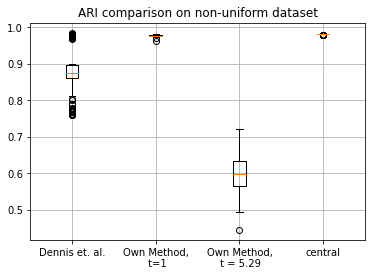

In [105]:
plt.boxplot(avg_scores_DS_SD, positions = [0])
plt.boxplot(avg_scores_sd_t1[-1,:], positions = [1])
plt.boxplot(avg_scores_sd_natT[-1,:], positions = [2])
plt.boxplot(scores_central_sd, positions = [3])
plt.xticks([0, 1, 2, 3], ["Dennis et. al.", "Own Method,\n t=1", "Own Method,\n t = 5.29", "central"])
plt.grid(True)
plt.title("ARI comparison on non-uniform dataset")

In [106]:
# save data
np.savetxt("om_synth_sd_natT.csv", avg_scores_sd_natT, delimiter = ",")
np.savetxt("om_synth_sd_t1.csv", avg_scores_sd_t1, delimiter = ",")
np.savetxt("ds_synth_sd.csv", avg_scores_DS_SD, delimiter = ",")
np.savetxt("cent_synth_sd.csv", scores_central_sd, delimiter = ",")

## Synthetic, varying points per cluster/noise

In [101]:
n_cluster_global = 16
crounds = 20
n_runs = 200
data_choice = "abl"
ppc = 50
beta = 0.1
noises = [1, 1.1, 1.2, 1.3, 1.4, 1.5]
scores_first = True

results_sfTrue = []
for noise in noises:
    out = run_synthetic_experiment(n_cluster_global, crounds, n_runs, data_choice, ppc=ppc, beta=beta, noise = noise, scores_first = scores_first)
    results_sfTrue.append(out)

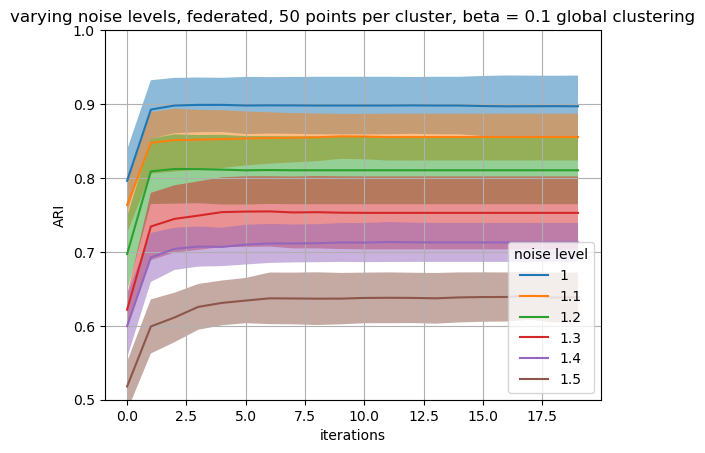

In [99]:
for result in results:
    plot_range(result['scores'].T, label = result['noise'])
    
plt.legend(title="noise level")
plt.ylabel("ARI")
plt.xlabel("iterations")
plt.title("varying noise levels, federated, " +  str(results[0]['ppc']) + " points per cluster, beta = " + str(results[0]['beta']) +  " global clustering")
plt.ylim([0.5, 1])
plt.grid(True)

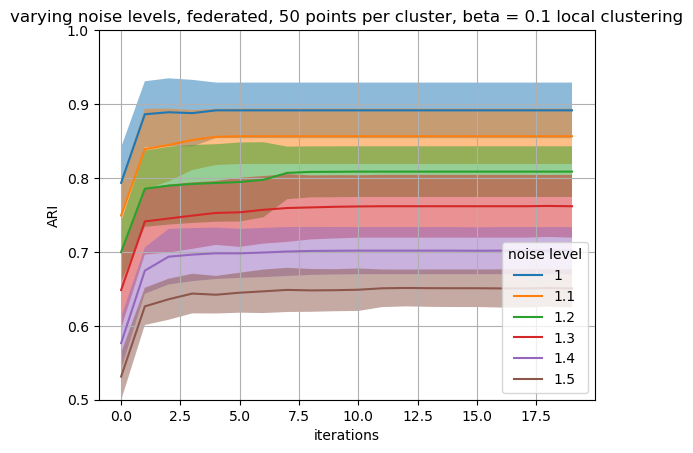

In [94]:
for result in results:
    plot_range(result['scores'].T, label = result['noise'])
    
plt.legend(title="noise level")
plt.ylabel("ARI")
plt.xlabel("iterations")
plt.title("varying noise levels, federated, " +  str(results[0]['ppc']) + " points per cluster, beta = " + str(results[0]['beta']) +  " local clustering")
plt.ylim([0.5, 1])
plt.grid(True)

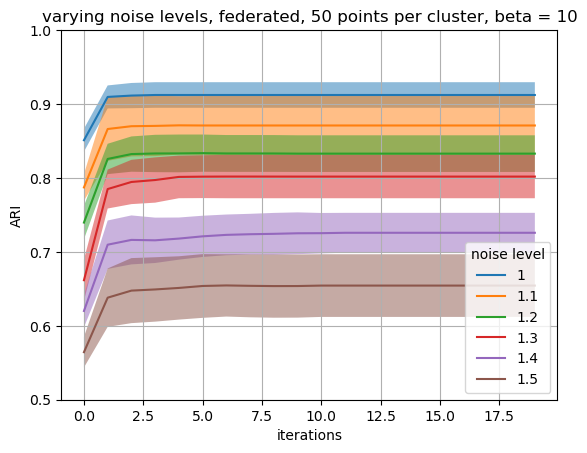

In [73]:
plot_range(out_n1['scores'].T, label = out_n1['noise'])
plot_range(out_n11['scores'].T, label = out_n11['noise'])
plot_range(out_n12['scores'].T, label = out_n12['noise'])
plot_range(out_n13['scores'].T, label = out_n13['noise'])
plot_range(out_n14['scores'].T, label = out_n14['noise'])
plot_range(out_n15['scores'].T, label = out_n15['noise'])


plt.legend(title="noise level")
plt.ylabel("ARI")
plt.xlabel("iterations")
plt.title("varying noise levels, federated, " +  str(out_n1['ppc']) + " points per cluster, beta = " + str(out_n1['beta']))
plt.ylim([0.5, 1])
plt.grid(True)

In [59]:
n_runs = 10
noises = [1, 1.1, 1.2, 1.3, 1.4, 1.5]
beta = 10
ppc = 50

scores_central_noise = np.zeros((len(noises), n_runs))

datasets = []
labels = []

for j, noise in enumerate(noises):
    for i in range(5):
        dataset, label = load_data(i, "abl", beta=beta, ppc=ppc, noise=noise)
        datasets.append(dataset)
        labels.append(label)

    data_full, labels_full = stack_data(datasets, labels)
    for n_run in range(n_runs):
        kmeans_cent = KMeans(n_clusters = 16, random_state=0 + n_run).fit(data_full)
        scores_central_noise[j, n_run] = adjusted_rand_score(labels_full, kmeans_cent.labels_)

In [102]:
n_runs = 200
noises = [1, 1.1, 1.2, 1.3, 1.4, 1.5]
#noises = [1]
beta = 10
ppc = 50
rounds = 20
scores_central_noise = np.zeros((len(noises), n_runs, rounds))

datasets = []
labels = []

for j, noise in enumerate(noises):
    for i in range(5):
        dataset, label = load_data(i, "abl", beta=beta, ppc=ppc, noise=noise)
        datasets.append(dataset)
        labels.append(label)

    data_full, labels_full = stack_data(datasets, labels)
    for n_run in range(n_runs):
        km = KMeans(n_init = 1, n_clusters = 16, random_state=0 + n_run, max_iter = 20, verbose = 0)
        #for r in range(rounds):
            #if r > 0:
                #km.cluster_centers = np.copy(cent_tmp)
        kmeans_cent = km.fit(data_full)
        scores_central_noise[j, n_run, r] = adjusted_rand_score(labels_full, kmeans_cent.labels_)
            #cent_tmp = np.copy(km.cluster_centers_)
            #km.set_params(max_iter = r + 2)

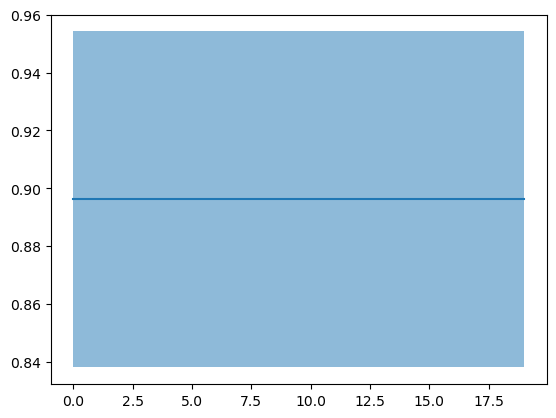

In [85]:
plot_range(scores_central_noise[0,:,:])

ValueError: X must have 2 or fewer dimensions

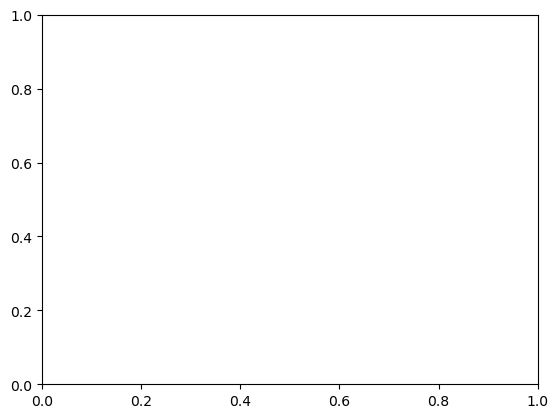

In [81]:
#plt.boxplot(scores[-1,:], positions = [0] )
plt.boxplot(scores_central_noise.T, positions = [0, 1, 2, 3, 4, 5])
plt.xticks([0,1,2,3,4,5], [1, 1.1, 1.2, 1.3, 1.4, 1.5])
plt.ylim([0.5, 1])
plt.grid(True)
plt.title("central clustering, varying noise levels")
plt.xlabel("noise level")
plt.ylabel("ARI")

## OLD

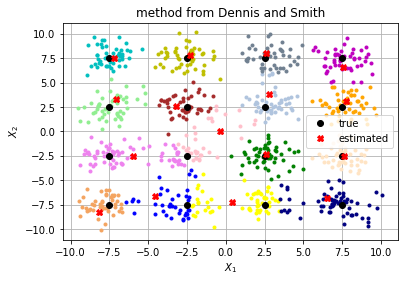

In [50]:
means_original = np.array([[-7.5, -7.5, -7.5, -7.5, -2.5, -2.5, -2.5, -2.5, 2.5, 2.5, 2.5, 2.5, 7.5, 7.5, 7.5, 7.5],
                           [-7.5, -2.5, 2.5, 7.5, -7.5, -2.5, 2.5, 7.5, -7.5, -2.5, 2.5, 7.5, -7.5, -2.5, 2.5, 7.5]])
dataset = np.vstack(datasets)


plot_federated(dataset, means_original, centers, title = "method from Dennis and Smith")